In [52]:
from rlwsd.utils import lemmatize_s
left, right = 'Люба вошла в двухкомнатную квартиру . Хоть и хрущевка зато есть горячая вода теплый туалет и под каждым окном отопительная', 'Мешала только война с соседями'
word = 'батарея'
context = lemmatize_s(left) + lemmatize_s(right)
context

['люба',
 'входить',
 'в',
 'двухкомнатный',
 'квартира',
 '.',
 'хоть',
 'и',
 'хрущевка',
 'зато',
 'быть',
 'горячий',
 'вода',
 'теплый',
 'туалет',
 'и',
 'под',
 'каждый',
 'окно',
 'отопительный',
 'мешать',
 'только',
 'война',
 'с',
 'сосед']

In [2]:
import rlwsd
model = rlwsd.SphericalModel.load(word)

In [23]:
model.disambiguate(left, word, right)

'2'

In [3]:
from rs.supervised import load_weights
weights = load_weights(word, '../../corpora/ad-nouns/')

In [53]:
for w in context:
    print('{:.2f} {}'.format(weights.get(w, -1), w))

-1.00 люба
0.05 входить
0.00 в
0.00 двухкомнатный
0.12 квартира
-1.00 .
0.00 хоть
0.00 и
0.67 хрущевка
0.00 зато
0.01 быть
1.00 горячий
0.31 вода
0.95 теплый
0.03 туалет
0.00 и
0.68 под
0.09 каждый
0.43 окно
3.74 отопительный
0.00 мешать
0.00 только
0.70 война
0.07 с
0.04 сосед


In [43]:
word_contexts = [
    lemmatize_s(left) + lemmatize_s(right) for left, _, right in (
        line.strip().split('\t') for line in open(
            '../../corpora/ad-nouns/ruTenTen/батарея.txt'))]

In [45]:
from rlwsd.w2v_client import w2v_vecs

vectors = []
for ctx in word_contexts:
    vectors.extend(v for v in w2v_vecs(ctx) if v is not None)

In [46]:
import random
random.shuffle(vectors)

In [54]:
from scipy.spatial.distance import cdist
context_vectors = [(w, weights[w], v) for w, v in zip(context, w2v_vecs(context))
                   if v is not None and w in weights]
sense_vectors = [v for _, v in sorted(model.sense_vectors.items())]
context_vector = model.cv((left, word, right))
dist_vectors = [v for _, _, v in context_vectors] + sense_vectors + [context_vector] + vectors[:500]
distances = cdist(dist_vectors, dist_vectors, 'cosine')
distances[distances < 0] = 0

In [61]:
from sklearn.manifold import TSNE
tsne = TSNE(2, metric='precomputed')
transformed = tsne.fit_transform(distances)

1 Батарея А2 под командованием А1 ‘Воинское подразделение в артиллерии или ракетных войсках А2, которым командует человек А1, состоящее из 2–3 взводов и имеющее в своем составе несколько орудий, или сами эти орудия’.
2 ‘Конструкция для отопления помещения, состоящая из соединенных друг с другом одинаковых частей, внутри которых находится горячая жидкость или пар, и соединенная трубами с источником нагревания’.
3 Батарея А1 ‘Источник электрического тока, являющийся частью или предназначенный для автономного питания прибора или устройства А1’.
4 Батарея А1 ‘Большое количество вертикально вытянутых однотипных предметов А1, расположенных рядами’.


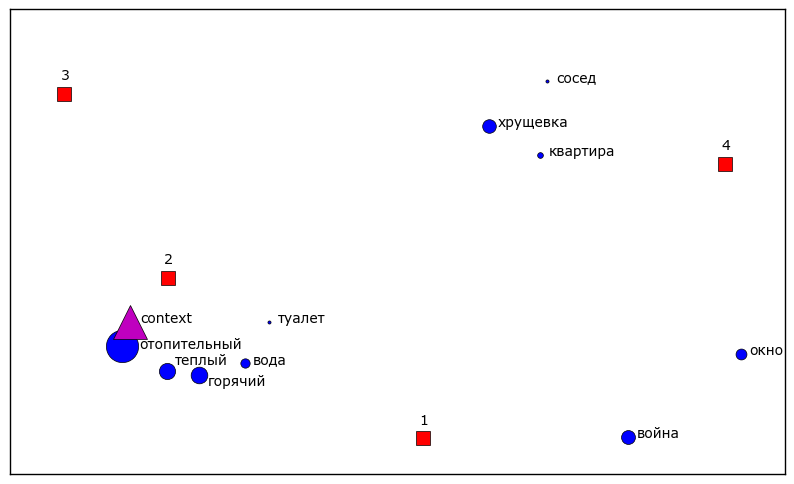

In [106]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
font = {'family': 'Verdana', 'weight': 'normal'}
plt.rc('font', **font)
for (w, weight, _), (x, y) in zip(context_vectors, transformed):
    if weight > 0.01:
        if w in {'под', 'с', 'входить', 'каждый'}: continue
        #print(w, x, y)
        plt.plot(x, y, marker='o', markersize=12*math.sqrt(weight), color='b')
        dx, dy = {
            'отопительный': (0.5, -0.1),
            'горячий': (0, -0.5),
            'теплый': (0, 0.4),
        }.get(w, (0, 0))
        plt.annotate(w, xy=(x + 0.5 + dx, y + dy))
for (sense, _), (x, y) in zip(sorted(model.sense_vectors.items()), transformed[len(context_vectors):]):
    plt.plot(x, y, marker='s', color='r', markersize=10)
    plt.annotate(sense, xy=(x - 0.2, y + 0.8))

x, y = transformed[len(context_vectors) + len(model.sense_vectors)]
plt.plot(x, y, marker='^', color='m', markersize=25)
plt.annotate('context', xy=(x + 0.6, y))

for sid, s in sorted(model.senses.items()):
    print(sid, s['meaning'])

plt.xlim((-30.0, 15.0))
plt.ylim((-30.0, -5.0))

plt.axes().get_xaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)

plt.savefig('context_repr_3.pdf')